In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

In [2]:
tc_df=pd.read_csv('Telco_Customer_Churn_Data.csv')
tc_df['TotalCharges'].replace(' ',np.NaN,inplace=True)##Replaing spaces(string) into missing value to avoid errors in convert to float
tc_df['TotalCharges']=tc_df['TotalCharges'].astype(float)


In [3]:
tc_df['SeniorCitizen']=tc_df['SeniorCitizen'].astype(object)


In [4]:
tc_df['SeniorCitizen']

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: SeniorCitizen, Length: 7043, dtype: object

In [5]:
corr_cols_df=tc_df.copy()
corr_cat_cols=[col for col in corr_cols_df.columns if corr_cols_df[col].dtype=='object'] 
corr_cont_cols=[col for col in corr_cols_df.columns if corr_cols_df[col].dtype=='int64' or corr_cols_df[col].dtype=='float64']


for col in corr_cont_cols:###Relacing MIss values with mean for total column just to avoid nan in finding p_values
    corr_cols_df[col].fillna(corr_cols_df[col].mean(),inplace=True)
for col in corr_cat_cols:
    corr_cols_df[col].fillna(corr_cols_df[col].mode(),inplace=True)

In [6]:
def chi_squ(col):
    contingency_table=pd.crosstab(corr_cols_df[col],corr_cols_df['Churn'])
    res=chi2_contingency(contingency_table)
    return res[1],col

data=[chi_squ(col) for col in corr_cat_cols]
cat_chi_sq_df=pd.DataFrame(data,columns=['p_value','col_name'])
corr_catg_cols=cat_chi_sq_df[cat_chi_sq_df['p_value']<0.05]
corr_catg_cols_names=list(corr_catg_cols['col_name'])  # Correlated catg columns
    

In [7]:
catg=corr_cols_df['Churn'].value_counts().index.tolist()

def anova(col):
    res=f_oneway(*[corr_cols_df[corr_cols_df['Churn']==cat][col] for cat in catg])
    return res[1],col

cont_data=[anova(col) for col in corr_cont_cols]

cont_anova_df=pd.DataFrame(cont_data,columns =['value', 'col_name'])
cont_anova_df['value']=cont_anova_df['value'].fillna(0)
cont_anova_df


,value,col_name
0,7.999058e-205,tenure
1,2.706646e-60,MonthlyCharges
2,4.233836e-64,TotalCharges


In [8]:
corr_cont_cols=cont_anova_df[cont_anova_df['value']<0.05]
corr_cont_col_names=list(corr_cont_cols['col_name'])
len(corr_cont_col_names)
corr_cont_cols


,value,col_name
0,7.999058e-205,tenure
1,2.706646e-60,MonthlyCharges
2,4.233836e-64,TotalCharges


In [9]:
tot_corr_col_names=corr_catg_cols_names + corr_cont_col_names

In [10]:
mainfo_df=tc_df.copy()## Creating copy of DF for deleting unwanted columns
mainfo_df.drop(columns=tot_corr_col_names,inplace=True)## Now this DF contains unwanted columns so that it can pass to next step
ls_cols_remove=list(mainfo_df.columns)
ls_cols_remove

['customerID', 'gender', 'PhoneService']

In [11]:
tc_df.drop(columns=ls_cols_remove,inplace=True)

In [12]:
y=tc_df['Churn']
tc_df.drop(columns=['Churn'],inplace=True)

In [13]:
cat_cols=[col for col in tc_df.columns if tc_df[col].dtype=='object']
con_cols=[col for col in tc_df.columns if tc_df[col].dtype=='int64' or tc_df[col].dtype=='float64']

In [14]:
tc_df.isnull().sum()
tc_df['TotalCharges'].isnull().sum()

11

In [15]:
mainfo_df_val=pd.DataFrame({'col_name':tc_df.columns,'na_count':tc_df.isnull().sum(),'pc_cnt':(tc_df.isnull().sum()/tc_df.shape[0])*100})
mainfo_df_val

,col_name,na_count,pc_cnt
SeniorCitizen,SeniorCitizen,0,0.000000
Partner,Partner,0,0.000000
Dependents,Dependents,0,0.000000
tenure,tenure,0,0.000000
MultipleLines,MultipleLines,0,0.000000
InternetService,InternetService,0,0.000000
OnlineSecurity,OnlineSecurity,0,0.000000
OnlineBackup,OnlineBackup,0,0.000000
DeviceProtection,DeviceProtection,0,0.000000
TechSupport,TechSupport,0,0.000000


In [16]:
x_train,x_test,y_train,y_test=train_test_split(tc_df,y,random_state=52,test_size=0.2)

In [17]:
for col in con_cols:
    x_train[col].fillna(x_train[col].mean(),inplace=True)
    x_test[col].fillna(x_train[col].mean(),inplace=True)

In [18]:
for col in cat_cols:
    x_train[col].fillna(x_train[col].mode()[0],inplace=True)
    x_test[col].fillna(x_train[col].mode()[0],inplace=True)

In [19]:
scaler=StandardScaler()

for col in con_cols:
    x_train[col]=scaler.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col]=scaler.transform(np.array(x_test[col]).reshape(-1,1))

In [20]:
cat_encd_train=pd.get_dummies(x_train[cat_cols])
cat_encd_test=pd.get_dummies(x_test[cat_cols])

In [21]:
cat_encd_train_final,cat_encd_test_final=cat_encd_train.align(cat_encd_test,join='inner',axis=1)

In [22]:
x_train_final=pd.concat([x_train[con_cols],cat_encd_train_final],axis=1)
x_test_final=pd.concat([x_test[con_cols],cat_encd_test_final],axis=1)
x_test_final.shape,x_train_final.shape

((1409, 41), (5634, 41))

In [23]:
logreg=LogisticRegression()
logreg.fit(x_train_final,y_train)

LogisticRegression()

In [24]:
y_test_pred=logreg.predict(x_test_final)

In [25]:
confusion_matrix(y_test,y_test_pred)

array([[914, 113],
       [153, 229]], dtype=int64)

In [26]:
precision_score(y_test,y_test_pred,pos_label='Yes')

0.6695906432748538

In [27]:
recall_score(y_test,y_test_pred,pos_label='Yes')

0.599476439790576

In [28]:
f1_score(y_test,y_test_pred,pos_label='Yes')

0.6325966850828729

Text(0.5, 1.0, 'AUC Curve')

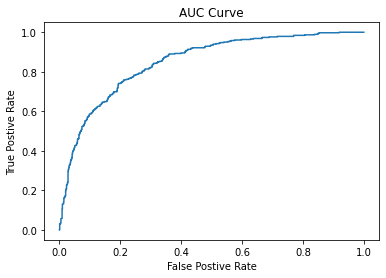

In [29]:
pos_probs=logreg.predict_proba(x_test_final)[::,1]
fpr,tpr,thresold=roc_curve(y_test,pos_probs,pos_label='Yes')
plt.plot(fpr,tpr)
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('AUC Curve')

In [30]:
roc_auc_score(y_test,pos_probs)

0.8488226267734519

In [31]:
logreg.score(x_train_final,y_train)
logreg.score(x_test_final,y_test)

0.8112136266855926

In [32]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier()
ada.fit(x_train_final,y_train)
ada.predict(x_train_final)
ada.predict(x_test_final)
ada.predict_log_proba(x_test_final)
ada.predict_proba(x_test_final)

array([[0.49743455, 0.50256545],
       [0.5221023 , 0.4778977 ],
       [0.52350277, 0.47649723],
       ...,
       [0.5040992 , 0.4959008 ],
       [0.49744201, 0.50255799],
       [0.50430301, 0.49569699]])

In [33]:
ada.score(x_train_final,y_train)
ada.score(x_test_final,y_test)

0.8062455642299503

In [34]:
from sklearn.tree import DecisionTreeClassifier
dtc= DecisionTreeClassifier()
dtc.fit(x_train_final,y_train)
dtc.predict(x_test_final)

array(['No', 'No', 'No', ..., 'Yes', 'No', 'Yes'], dtype=object)

# Hyperparameter Tuning for DecisionTreeClassifier

In [35]:
from sklearn.model_selection import GridSearchCV

dtc=DecisionTreeClassifier()

hyp_dict={ 
           'max_depth':[5,6,7,8],
           'min_samples_split':[4,5,7,8],
           'max_leaf_nodes':[5,7,8,9],
           'min_samples_leaf':[2,3,4,6] 
         }
gcv=GridSearchCV(estimator=dtc,param_grid=hyp_dict,cv=5,verbose=21)
gcv.fit(x_train_final,y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5; 1/256] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 1/5; 1/256] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 2/5; 1/256] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 2/5; 1/256] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 3/5; 1/256] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 3/5; 1/256] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 4/5; 1/256] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 4/5; 1/256] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 5/5; 1/256] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 5/5; 1/256] END max_dep

[CV 5/5; 9/256] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 1/5; 10/256] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5
[CV 1/5; 10/256] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 2/5; 10/256] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5
[CV 2/5; 10/256] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 3/5; 10/256] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5
[CV 3/5; 10/256] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 4/5; 10/256] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5
[CV 4/5; 10/256] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 5/5; 10/256] START max_depth=5, max_leaf_nodes=5, min_samples

[CV 5/5; 17/256] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 1/5; 18/256] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=5
[CV 1/5; 18/256] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 2/5; 18/256] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=5
[CV 2/5; 18/256] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 3/5; 18/256] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=5
[CV 3/5; 18/256] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 4/5; 18/256] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=5
[CV 4/5; 18/256] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 5/5; 18/256] START max_depth=5, max_leaf_nodes=7, min_sample

[CV 5/5; 25/256] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 1/5; 26/256] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5
[CV 1/5; 26/256] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 2/5; 26/256] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5
[CV 2/5; 26/256] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 3/5; 26/256] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5
[CV 3/5; 26/256] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 4/5; 26/256] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5
[CV 4/5; 26/256] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 5/5; 26/256] START max_depth=5, max_leaf_nodes=7, min_sample

[CV 1/5; 34/256] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 2/5; 34/256] START max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5
[CV 2/5; 34/256] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 3/5; 34/256] START max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5
[CV 3/5; 34/256] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 4/5; 34/256] START max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5
[CV 4/5; 34/256] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 5/5; 34/256] START max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5
[CV 5/5; 34/256] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 1/5; 35/256] START max_depth=5, max_leaf_nodes=8, min_sample

[CV 3/5; 42/256] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 4/5; 42/256] START max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5
[CV 4/5; 42/256] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 5/5; 42/256] START max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5
[CV 5/5; 42/256] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 1/5; 43/256] START max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7
[CV 1/5; 43/256] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 2/5; 43/256] START max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7
[CV 2/5; 43/256] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 3/5; 43/256] START max_depth=5, max_leaf_nodes=8, min_sample

[CV 1/5; 51/256] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 2/5; 51/256] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7
[CV 2/5; 51/256] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 3/5; 51/256] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7
[CV 3/5; 51/256] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 4/5; 51/256] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7
[CV 4/5; 51/256] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 5/5; 51/256] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7
[CV 5/5; 51/256] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 1/5; 52/256] START max_depth=5, max_leaf_nodes=9, min_sample

[CV 4/5; 59/256] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 5/5; 59/256] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7
[CV 5/5; 59/256] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 1/5; 60/256] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=8
[CV 1/5; 60/256] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 2/5; 60/256] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=8
[CV 2/5; 60/256] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 3/5; 60/256] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=8
[CV 3/5; 60/256] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 4/5; 60/256] START max_depth=5, max_leaf_nodes=9, min_sample

[CV 3/5; 68/256] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV 4/5; 68/256] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8
[CV 4/5; 68/256] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV 5/5; 68/256] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8
[CV 5/5; 68/256] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV 1/5; 69/256] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 1/5; 69/256] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 2/5; 69/256] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 2/5; 69/256] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 69/256] START max_depth=6, max_leaf_nodes=5, min_sample

[CV 5/5; 76/256] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 1/5; 77/256] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=4
[CV 1/5; 77/256] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 2/5; 77/256] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=4
[CV 2/5; 77/256] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 3/5; 77/256] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=4
[CV 3/5; 77/256] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 4/5; 77/256] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=4
[CV 4/5; 77/256] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 5/5; 77/256] START max_depth=6, max_leaf_nodes=5, min_sample

[CV 4/5; 85/256] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 85/256] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 85/256] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 1/5; 86/256] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5
[CV 1/5; 86/256] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 86/256] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5
[CV 2/5; 86/256] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 3/5; 86/256] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5
[CV 3/5; 86/256] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 4/5; 86/256] START max_depth=6, max_leaf_nodes=7, min_sample

[CV 3/5; 94/256] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 4/5; 94/256] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=5
[CV 4/5; 94/256] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 5/5; 94/256] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=5
[CV 5/5; 94/256] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 1/5; 95/256] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=7
[CV 1/5; 95/256] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 2/5; 95/256] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=7
[CV 2/5; 95/256] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 3/5; 95/256] START max_depth=6, max_leaf_nodes=7, min_sample

[CV 4/5; 102/256] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 5/5; 102/256] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=5
[CV 5/5; 102/256] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 1/5; 103/256] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=7
[CV 1/5; 103/256] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 2/5; 103/256] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=7
[CV 2/5; 103/256] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 3/5; 103/256] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=7
[CV 3/5; 103/256] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 4/5; 103/256] START max_depth=6, max_leaf_nodes=8, 

[CV 3/5; 111/256] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 4/5; 111/256] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=7
[CV 4/5; 111/256] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 5/5; 111/256] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=7
[CV 5/5; 111/256] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 1/5; 112/256] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=8
[CV 1/5; 112/256] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 2/5; 112/256] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=8
[CV 2/5; 112/256] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 3/5; 112/256] START max_depth=6, max_leaf_nodes=8, 

[CV 5/5; 119/256] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 1/5; 120/256] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=8
[CV 1/5; 120/256] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 2/5; 120/256] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=8
[CV 2/5; 120/256] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 3/5; 120/256] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=8
[CV 3/5; 120/256] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 4/5; 120/256] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=8
[CV 4/5; 120/256] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 5/5; 120/256] START max_depth=6, max_leaf_nodes=9, 

[CV 3/5; 128/256] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 4/5; 128/256] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=8
[CV 4/5; 128/256] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 5/5; 128/256] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=8
[CV 5/5; 128/256] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 1/5; 129/256] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 1/5; 129/256] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 2/5; 129/256] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 2/5; 129/256] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 3/5; 129/256] START max_depth=7, max_leaf_nodes=5, 

[CV 5/5; 136/256] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 1/5; 137/256] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 1/5; 137/256] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 2/5; 137/256] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 2/5; 137/256] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 3/5; 137/256] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 3/5; 137/256] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 4/5; 137/256] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 4/5; 137/256] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 5/5; 137/256] START max_depth=7, max_leaf_nodes=5, 

[CV 1/5; 145/256] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 2/5; 145/256] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 2/5; 145/256] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 3/5; 145/256] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 3/5; 145/256] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 4/5; 145/256] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 4/5; 145/256] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 5/5; 145/256] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 5/5; 145/256] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 1/5; 146/256] START max_depth=7, max_leaf_nodes=7, 

[CV 3/5; 153/256] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4
[CV 3/5; 153/256] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 4/5; 153/256] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4
[CV 4/5; 153/256] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 5/5; 153/256] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4
[CV 5/5; 153/256] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 1/5; 154/256] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5
[CV 1/5; 154/256] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 2/5; 154/256] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5
[CV 2/5; 154/256] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=4, 

[CV 5/5; 161/256] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 1/5; 162/256] START max_depth=7, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5
[CV 1/5; 162/256] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 2/5; 162/256] START max_depth=7, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5
[CV 2/5; 162/256] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 3/5; 162/256] START max_depth=7, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5
[CV 3/5; 162/256] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 4/5; 162/256] START max_depth=7, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5
[CV 4/5; 162/256] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 5/5; 162/256] START max_depth=7, max_leaf_nodes=8, 

[CV 3/5; 170/256] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 4/5; 170/256] START max_depth=7, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5
[CV 4/5; 170/256] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 5/5; 170/256] START max_depth=7, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5
[CV 5/5; 170/256] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 1/5; 171/256] START max_depth=7, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7
[CV 1/5; 171/256] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 2/5; 171/256] START max_depth=7, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7
[CV 2/5; 171/256] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 3/5; 171/256] START max_depth=7, max_leaf_nodes=8, 

[CV 5/5; 178/256] START max_depth=7, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=5
[CV 5/5; 178/256] END max_depth=7, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 1/5; 179/256] START max_depth=7, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7
[CV 1/5; 179/256] END max_depth=7, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 2/5; 179/256] START max_depth=7, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7
[CV 2/5; 179/256] END max_depth=7, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 3/5; 179/256] START max_depth=7, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7
[CV 3/5; 179/256] END max_depth=7, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 4/5; 179/256] START max_depth=7, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=7
[CV 4/5; 179/256] END max_depth=7, max_leaf_nodes=9, min_samples_leaf=2, 

[CV 4/5; 186/256] END max_depth=7, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 5/5; 186/256] START max_depth=7, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=5
[CV 5/5; 186/256] END max_depth=7, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 1/5; 187/256] START max_depth=7, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7
[CV 1/5; 187/256] END max_depth=7, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 2/5; 187/256] START max_depth=7, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7
[CV 2/5; 187/256] END max_depth=7, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 3/5; 187/256] START max_depth=7, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7
[CV 3/5; 187/256] END max_depth=7, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 4/5; 187/256] START max_depth=7, max_leaf_nodes=9, 

[CV 5/5; 194/256] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 1/5; 195/256] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7
[CV 1/5; 195/256] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 2/5; 195/256] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7
[CV 2/5; 195/256] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 3/5; 195/256] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7
[CV 3/5; 195/256] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 4/5; 195/256] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7
[CV 4/5; 195/256] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 5/5; 195/256] START max_depth=8, max_leaf_nodes=5, 

[CV 2/5; 203/256] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 3/5; 203/256] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 3/5; 203/256] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 4/5; 203/256] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 4/5; 203/256] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 5/5; 203/256] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 5/5; 203/256] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 1/5; 204/256] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8
[CV 1/5; 204/256] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 2/5; 204/256] START max_depth=8, max_leaf_nodes=5, 

[CV 4/5; 211/256] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 5/5; 211/256] START max_depth=8, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=7
[CV 5/5; 211/256] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 1/5; 212/256] START max_depth=8, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8
[CV 1/5; 212/256] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV 2/5; 212/256] START max_depth=8, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8
[CV 2/5; 212/256] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV 3/5; 212/256] START max_depth=8, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8
[CV 3/5; 212/256] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV 4/5; 212/256] START max_depth=8, max_leaf_nodes=7, 

[CV 2/5; 220/256] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 3/5; 220/256] START max_depth=8, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8
[CV 3/5; 220/256] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 4/5; 220/256] START max_depth=8, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8
[CV 4/5; 220/256] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 5/5; 220/256] START max_depth=8, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8
[CV 5/5; 220/256] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 1/5; 221/256] START max_depth=8, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=4
[CV 1/5; 221/256] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 2/5; 221/256] START max_depth=8, max_leaf_nodes=7, 

[CV 3/5; 228/256] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV 4/5; 228/256] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=8
[CV 4/5; 228/256] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV 5/5; 228/256] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=8
[CV 5/5; 228/256] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV 1/5; 229/256] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4
[CV 1/5; 229/256] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 2/5; 229/256] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4
[CV 2/5; 229/256] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 229/256] START max_depth=8, max_leaf_nodes=8, 

[CV 1/5; 237/256] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 2/5; 237/256] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4
[CV 2/5; 237/256] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 3/5; 237/256] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4
[CV 3/5; 237/256] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 4/5; 237/256] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4
[CV 4/5; 237/256] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 5/5; 237/256] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4
[CV 5/5; 237/256] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 1/5; 238/256] START max_depth=8, max_leaf_nodes=8, 

[CV 3/5; 245/256] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 245/256] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4
[CV 4/5; 245/256] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 245/256] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 245/256] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 1/5; 246/256] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5
[CV 1/5; 246/256] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 246/256] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5
[CV 2/5; 246/256] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 3/5; 246/256] START max_depth=8, max_leaf_nodes=9, 

[CV 1/5; 254/256] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 2/5; 254/256] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=5
[CV 2/5; 254/256] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 3/5; 254/256] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=5
[CV 3/5; 254/256] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 4/5; 254/256] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=5
[CV 4/5; 254/256] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 5/5; 254/256] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=5
[CV 5/5; 254/256] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 1/5; 255/256] START max_depth=8, max_leaf_nodes=9, 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 6, 7, 8],
                         'max_leaf_nodes': [5, 7, 8, 9],
                         'min_samples_leaf': [2, 3, 4, 6],
                         'min_samples_split': [4, 5, 7, 8]},
             verbose=21)

In [36]:
gcv.best_params_
gcv.predict(x_test_final)
dtc_hp_pred=gcv.predict(x_test_final)

In [37]:
from sklearn.model_selection import RandomizedSearchCV
rcv=RandomizedSearchCV(estimator=dtc,param_distributions=hyp_dict,cv=5,n_iter=120,verbose=21)
rcv.fit(x_train_final,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5; 1/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 1/5; 1/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 2/5; 1/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 2/5; 1/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 1/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 3/5; 1/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 1/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 4/5; 1/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 1/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 1/120] END max_dept

[CV 3/5; 9/120] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 4/5; 9/120] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=4
[CV 4/5; 9/120] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 5/5; 9/120] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=4
[CV 5/5; 9/120] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 1/5; 10/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=7
[CV 1/5; 10/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 2/5; 10/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=7
[CV 2/5; 10/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 3/5; 10/120] START max_depth=6, max_leaf_nodes=7, min_samples_lea

[CV 1/5; 18/120] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 2/5; 18/120] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=8
[CV 2/5; 18/120] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 3/5; 18/120] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=8
[CV 3/5; 18/120] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 4/5; 18/120] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=8
[CV 4/5; 18/120] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 5/5; 18/120] START max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=8
[CV 5/5; 18/120] END max_depth=6, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 1/5; 19/120] START max_depth=8, max_leaf_nodes=7, min_sample

[CV 3/5; 26/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 4/5; 26/120] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7
[CV 4/5; 26/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 5/5; 26/120] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7
[CV 5/5; 26/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=7; total time=   0.0s
[CV 1/5; 27/120] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7
[CV 1/5; 27/120] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 2/5; 27/120] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7
[CV 2/5; 27/120] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 3/5; 27/120] START max_depth=8, max_leaf_nodes=9, min_sample

[CV 2/5; 35/120] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 35/120] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4
[CV 3/5; 35/120] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 35/120] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4
[CV 4/5; 35/120] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 35/120] START max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 35/120] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 1/5; 36/120] START max_depth=5, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4
[CV 1/5; 36/120] END max_depth=5, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 2/5; 36/120] START max_depth=5, max_leaf_nodes=8, min_sample

[CV 5/5; 43/120] END max_depth=6, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 1/5; 44/120] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 1/5; 44/120] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 2/5; 44/120] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 2/5; 44/120] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 3/5; 44/120] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 3/5; 44/120] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 4/5; 44/120] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 4/5; 44/120] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 5/5; 44/120] START max_depth=8, max_leaf_nodes=5, min_sample

[CV 4/5; 52/120] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 5/5; 52/120] START max_depth=8, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=8
[CV 5/5; 52/120] END max_depth=8, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 1/5; 53/120] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 1/5; 53/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 2/5; 53/120] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 2/5; 53/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 53/120] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 3/5; 53/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 53/120] START max_depth=5, max_leaf_nodes=5, min_sample

[CV 2/5; 61/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 3/5; 61/120] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5
[CV 3/5; 61/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 4/5; 61/120] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5
[CV 4/5; 61/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 5/5; 61/120] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5
[CV 5/5; 61/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 1/5; 62/120] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=5
[CV 1/5; 62/120] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 62/120] START max_depth=7, max_leaf_nodes=5, min_sample

[CV 1/5; 70/120] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 70/120] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5
[CV 2/5; 70/120] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 3/5; 70/120] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5
[CV 3/5; 70/120] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 4/5; 70/120] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5
[CV 4/5; 70/120] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 5/5; 70/120] START max_depth=5, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5
[CV 5/5; 70/120] END max_depth=5, max_leaf_nodes=9, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 1/5; 71/120] START max_depth=8, max_leaf_nodes=5, min_sample

[CV 4/5; 78/120] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 5/5; 78/120] START max_depth=8, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=4
[CV 5/5; 78/120] END max_depth=8, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 1/5; 79/120] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5
[CV 1/5; 79/120] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 2/5; 79/120] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5
[CV 2/5; 79/120] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 3/5; 79/120] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5
[CV 3/5; 79/120] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 4/5; 79/120] START max_depth=8, max_leaf_nodes=8, min_sample

[CV 3/5; 87/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 3/5; 87/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 4/5; 87/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 4/5; 87/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 5/5; 87/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 5/5; 87/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV 1/5; 88/120] START max_depth=7, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=7
[CV 1/5; 88/120] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 2/5; 88/120] START max_depth=7, max_leaf_nodes=8, min_samples_leaf=6, min_samples_split=7
[CV 2/5; 88/120] END max_depth=7, max_leaf_nodes=8, min_samples_leaf=6, min_sample

[CV 4/5; 95/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 5/5; 95/120] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=8
[CV 5/5; 95/120] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 1/5; 96/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5
[CV 1/5; 96/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 96/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5
[CV 2/5; 96/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 3/5; 96/120] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5
[CV 3/5; 96/120] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 4/5; 96/120] START max_depth=6, max_leaf_nodes=7, min_sample

[CV 4/5; 103/120] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 5/5; 103/120] START max_depth=8, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7
[CV 5/5; 103/120] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 1/5; 104/120] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5
[CV 1/5; 104/120] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 2/5; 104/120] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5
[CV 2/5; 104/120] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 3/5; 104/120] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5
[CV 3/5; 104/120] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 4/5; 104/120] START max_depth=6, max_leaf_nodes=5, 

[CV 5/5; 111/120] END max_depth=8, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV 1/5; 112/120] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=7
[CV 1/5; 112/120] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 2/5; 112/120] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=7
[CV 2/5; 112/120] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 3/5; 112/120] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=7
[CV 3/5; 112/120] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 4/5; 112/120] START max_depth=8, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=7
[CV 4/5; 112/120] END max_depth=8, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 5/5; 112/120] START max_depth=8, max_leaf_nodes=5, 

[CV 4/5; 120/120] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 5/5; 120/120] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=8
[CV 5/5; 120/120] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=8; total time=   0.0s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=120,
                   param_distributions={'max_depth': [5, 6, 7, 8],
                                        'max_leaf_nodes': [5, 7, 8, 9],
                                        'min_samples_leaf': [2, 3, 4, 6],
                                        'min_samples_split': [4, 5, 7, 8]},
                   verbose=21)

In [38]:
rcv.best_params_
rcv.predict(x_test_final)
dtc_hp_pred=rcv.predict(x_test_final)